# CSC 4601 - Final Project
Adam Haile, Alec Nartatez, Dominic Zagra  
11/21/2024

## Importing the Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")
df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [3]:
X = df.drop(columns=['label'])
X = X.drop(columns=X.select_dtypes(include='object').columns)
y = df['label']

## Finding Correlations and Preprocessing

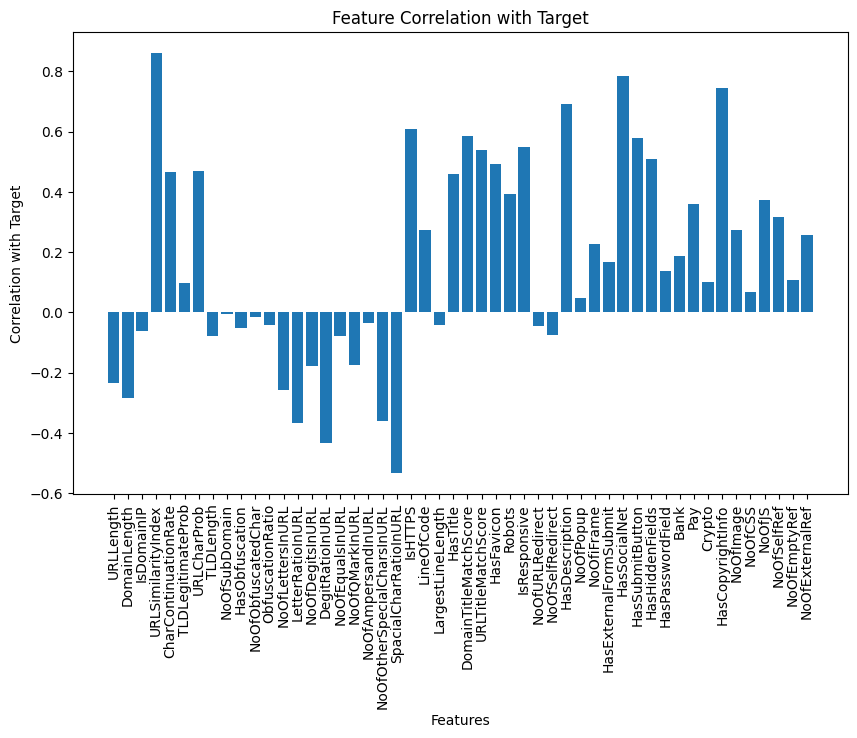

In [4]:
correlation_with_target = X.corrwith(y)
plt.figure(figsize=(10, 6))
plt.bar(correlation_with_target.index, correlation_with_target.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.title('Feature Correlation with Target')
plt.show()

In [5]:
X = X.drop(columns=['URLSimilarityIndex', 'LargestLineLength', 'HasTitle', 'HasFavicon', 'URLTitleMatchScore', 'IsResponsive', 'NoOfURLRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasCopyrightInfo', 'HasSocialNet', 'HasPasswordField', 'HasSubmitButton', 'HasHiddenFields', 'Bank', 'Pay', 'Crypto', 'NoOfImage', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'LineOfCode', 'NoOfCSS', 'DomainTitleMatchScore'])

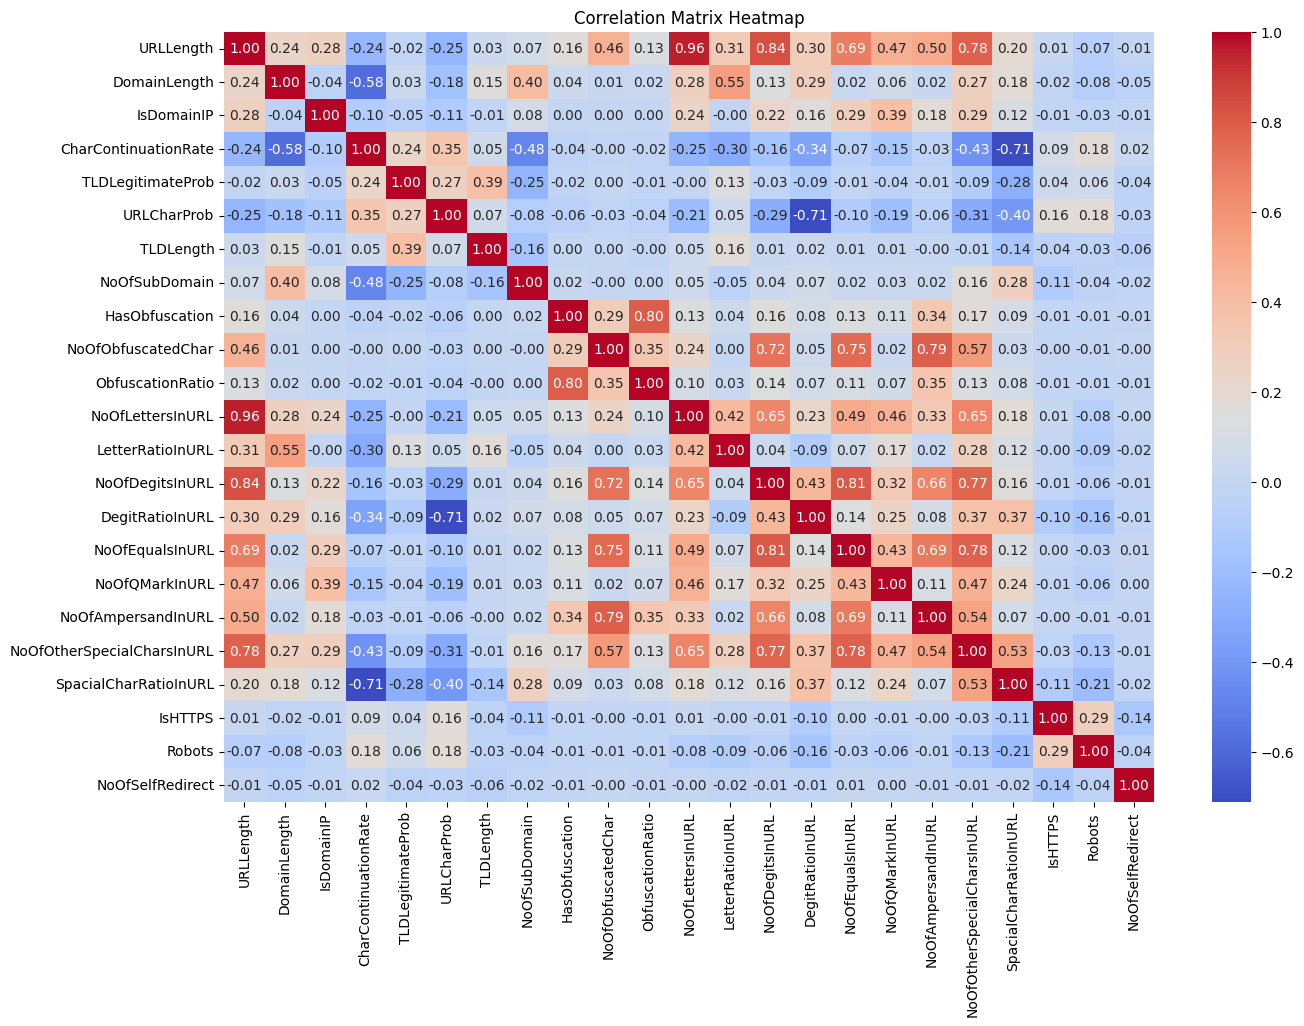

In [6]:
# Calculate the correlation matrix
corr_matrix = X.corr()

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

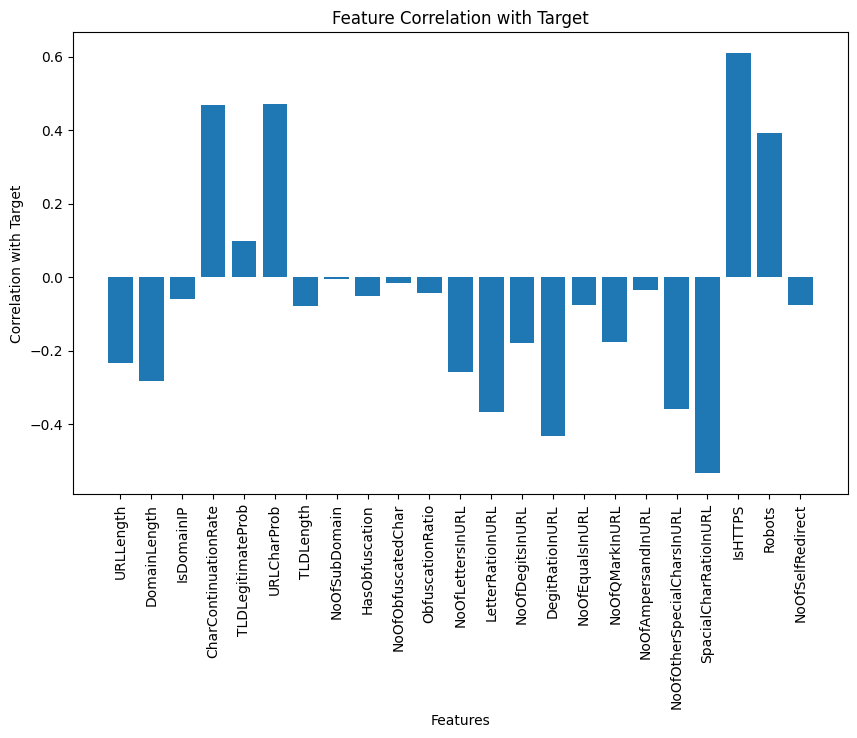

In [7]:
correlation_with_target = X.corrwith(y)
plt.figure(figsize=(10, 6))
plt.bar(correlation_with_target.index, correlation_with_target.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.title('Feature Correlation with Target')
plt.show()

## Fitting a Baseline Model

In [8]:
# %pip install xgboost
# %pip install graphviz
# %pip install optuna
from xgboost import XGBClassifier

In [9]:
num_trees = 4
bst = XGBClassifier(n_estimators=num_trees, max_depth=5, learning_rate=0.3, objective='binary:logistic')

In [10]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    bst.fit(X_train, y_train)

    accuracy = bst.score(X_test, y_test)
    accuracies.append(accuracy)
    print(f"Fold accuracy: {accuracy:.4f}")

print("Mean accuracy:", sum(accuracies) / len(accuracies))

Fold accuracy: 0.9903
Fold accuracy: 0.9859
Fold accuracy: 0.9886
Fold accuracy: 0.9884
Fold accuracy: 0.9890
Mean accuracy: 0.9884687970482835


<Figure size 2000x1000 with 0 Axes>

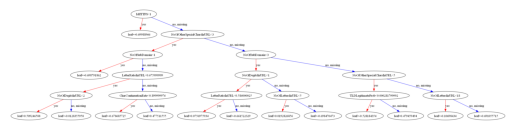

<Figure size 2000x1000 with 0 Axes>

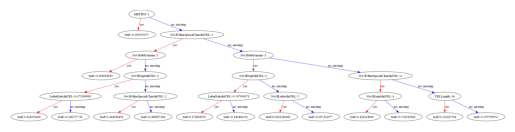

<Figure size 2000x1000 with 0 Axes>

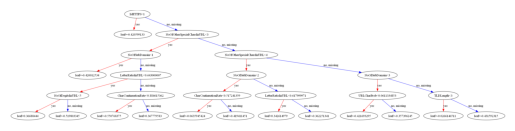

<Figure size 2000x1000 with 0 Axes>

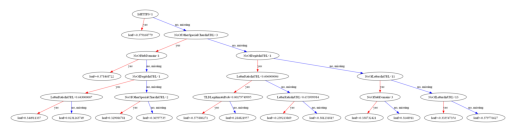

In [11]:
import os
from xgboost import plot_tree

os.makedirs("baseline_tree_plots", exist_ok=True)
for i in range(num_trees):
    plt.figure(figsize=(20, 10))  # Increase figure size
    plot_tree(bst, num_trees=i)
    plt.savefig(f'baseline_tree_plots/tree_plot_high_res_{i}.png', dpi=600)  # Save with high resolution
    plt.show()

## Hyperparameter Tuning

In [12]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    model = XGBClassifier(eval_metric='logloss', **params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best Parameters:", study.best_params)
print("Best Accuracy:", study.best_value)

C:\Users\hailea\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-08 14:00:06,194] A new study created in memory with name: no-name-a09b1521-cbf3-4894-80d9-5b13d4332155
[I 2024-12-08 14:00:08,349] Trial 0 finished with value: 0.9960240913904193 and parameters: {'learning_rate': 0.12375233036823223, 'max_depth': 7, 'n_estimators': 28, 'subsample': 0.5534924419138838}. Best is trial 0 with value: 0.9960240913904193.
[I 2024-12-08 14:00:09,801] Trial 1 finished with value: 0.9874043055918922 and parameters: {'learning_rate': 0.046236749819026916, 'max_depth': 5, 'n_estimators': 21, 'subsample': 0.7745290303850507}. Best is trial 0 with value: 0.9960240913904193.
[I 2024-12-08 14:00:11,529] Trial 2 finished with value: 0.9960240918119556 and parameters: {'learning_rate': 0.1583159

Best Parameters: {'learning_rate': 0.2681157633786404, 'max_depth': 10, 'n_estimators': 48, 'subsample': 0.9412239177801738}
Best Accuracy: 0.9973599965123755


In [13]:
from sklearn.metrics import precision_score, recall_score

# Fit the model with the best parameters
bst = XGBClassifier(**study.best_params)
bst.fit(X_train, y_train)

# Predict on the test set
y_pred = bst.predict(X_test)

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.9959
Recall: 0.9997


<Figure size 2000x1000 with 0 Axes>

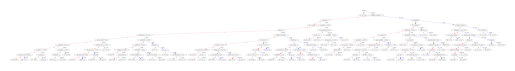

<Figure size 2000x1000 with 0 Axes>

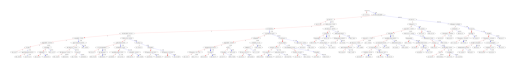

<Figure size 2000x1000 with 0 Axes>

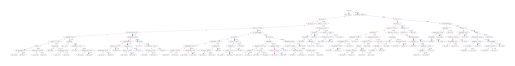

<Figure size 2000x1000 with 0 Axes>

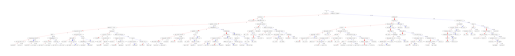

<Figure size 2000x1000 with 0 Axes>

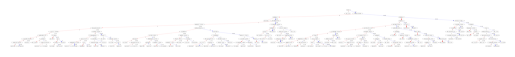

<Figure size 2000x1000 with 0 Axes>

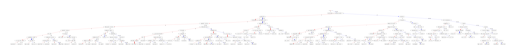

<Figure size 2000x1000 with 0 Axes>

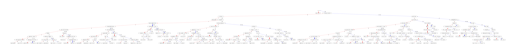

<Figure size 2000x1000 with 0 Axes>

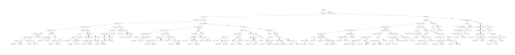

<Figure size 2000x1000 with 0 Axes>

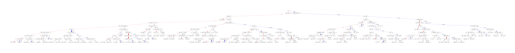

<Figure size 2000x1000 with 0 Axes>

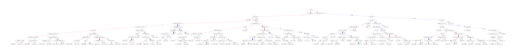

<Figure size 2000x1000 with 0 Axes>

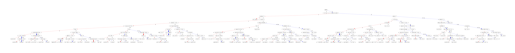

<Figure size 2000x1000 with 0 Axes>

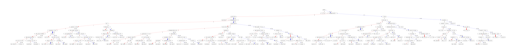

<Figure size 2000x1000 with 0 Axes>

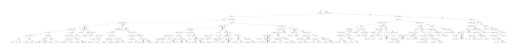

<Figure size 2000x1000 with 0 Axes>

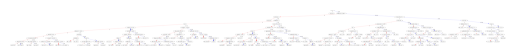

<Figure size 2000x1000 with 0 Axes>

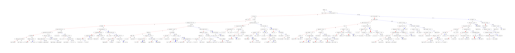

<Figure size 2000x1000 with 0 Axes>

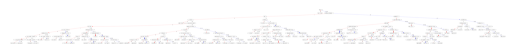

<Figure size 2000x1000 with 0 Axes>

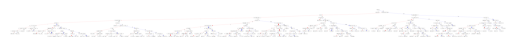

<Figure size 2000x1000 with 0 Axes>

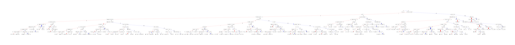

<Figure size 2000x1000 with 0 Axes>

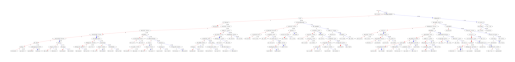

<Figure size 2000x1000 with 0 Axes>

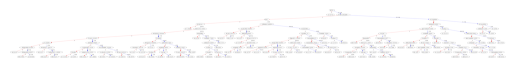

<Figure size 2000x1000 with 0 Axes>

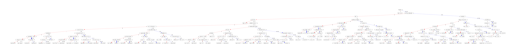

<Figure size 2000x1000 with 0 Axes>

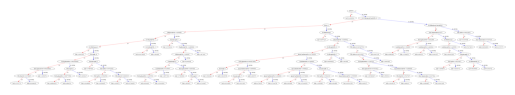

<Figure size 2000x1000 with 0 Axes>

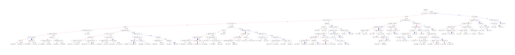

<Figure size 2000x1000 with 0 Axes>

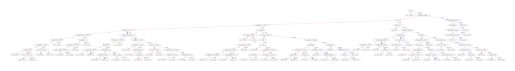

<Figure size 2000x1000 with 0 Axes>

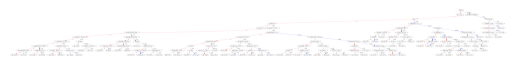

<Figure size 2000x1000 with 0 Axes>

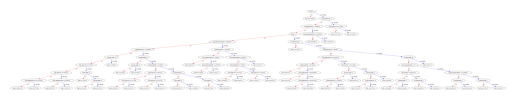

<Figure size 2000x1000 with 0 Axes>

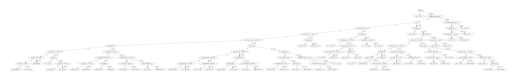

<Figure size 2000x1000 with 0 Axes>

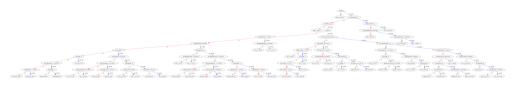

<Figure size 2000x1000 with 0 Axes>

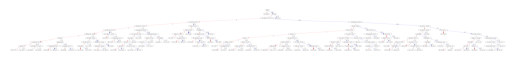

<Figure size 2000x1000 with 0 Axes>

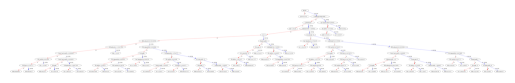

<Figure size 2000x1000 with 0 Axes>

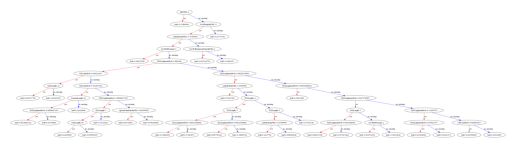

<Figure size 2000x1000 with 0 Axes>

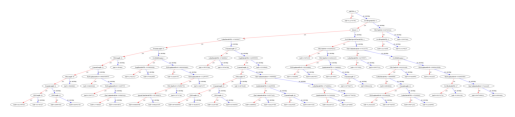

<Figure size 2000x1000 with 0 Axes>

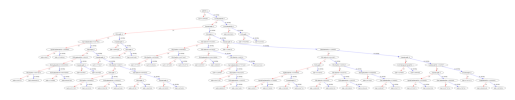

<Figure size 2000x1000 with 0 Axes>

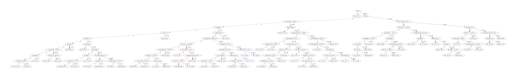

<Figure size 2000x1000 with 0 Axes>

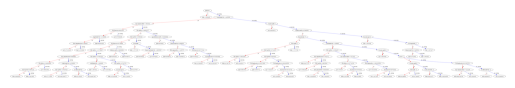

<Figure size 2000x1000 with 0 Axes>

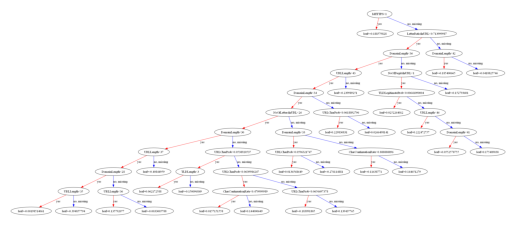

<Figure size 2000x1000 with 0 Axes>

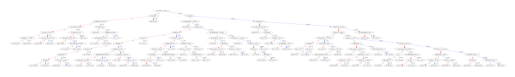

<Figure size 2000x1000 with 0 Axes>

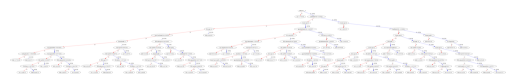

<Figure size 2000x1000 with 0 Axes>

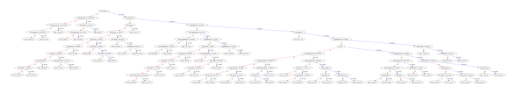

<Figure size 2000x1000 with 0 Axes>

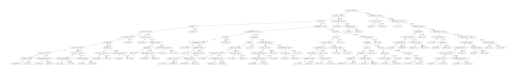

<Figure size 2000x1000 with 0 Axes>

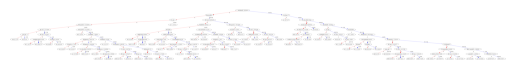

<Figure size 2000x1000 with 0 Axes>

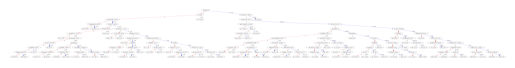

<Figure size 2000x1000 with 0 Axes>

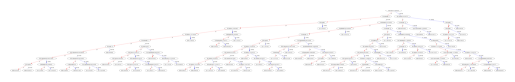

<Figure size 2000x1000 with 0 Axes>

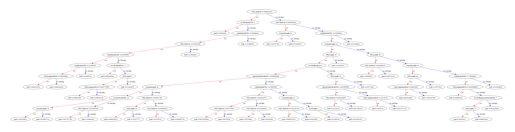

<Figure size 2000x1000 with 0 Axes>

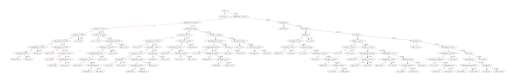

<Figure size 2000x1000 with 0 Axes>

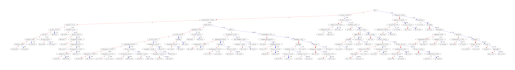

<Figure size 2000x1000 with 0 Axes>

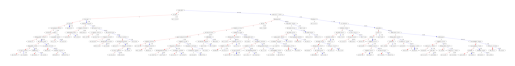

<Figure size 2000x1000 with 0 Axes>

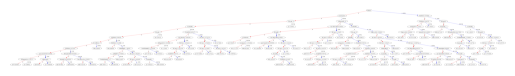

In [14]:
bst = XGBClassifier(**study.best_params)
bst.fit(X_train, y_train)

os.makedirs("bayesian_tree_plots", exist_ok=True)
for i in range(study.best_params["n_estimators"]):
    plt.figure(figsize=(20, 10))  # Increase figure size
    plot_tree(bst, num_trees=i)
    plt.savefig(f'bayesian_tree_plots/tree_plot_high_res_{i}.png', dpi=1200)  # Save with high resolution
    plt.show()

In [15]:
import joblib

# Save the model to a file
joblib.dump(bst, 'xgboost_model.pkl')

print("Model saved to xgboost_model.pkl")

Model saved to xgboost_model.pkl
